# Exoplanet Hunting in Deep Space
Machine Learning project on preprocessed data from the NASA Kepler space telescope. Hosted on Kaggle: https://www.kaggle.com/keplersmachines/kepler-labelled-time-series-data
<br>
The data is labeled and cleaned. The rows represent one solar system. Columns the flux emitted by the system over time. The data gives no information about the time between two measurements. Column label is indicates if there are exoplanets present in the system. 1 means there are no confirmed exoplanets, 2 means there is at least one confirmed exoplanet in the system.

Trainset:

- 5087 rows or observations.
- 3198 columns or features.
- Column 1 is the label vector. Columns 2 - 3198 are the flux values over time.
- 37 confirmed exoplanet-stars and 5050 non-exoplanet-stars.

Testset:

- 570 rows or observations.
- 3198 columns or features.
- Column 1 is the label vector. Columns 2 - 3198 are the flux values over time.
- 5 confirmed exoplanet-stars and 565 non-exoplanet-stars.

In [86]:
#import libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#timer
from timeit import default_timer as timer

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

## Preprocessing
### Loading Data and first inspection

In [2]:
#read training data
df_train = pd.read_csv('./exoTrain.csv')
display(df_train.head(3))
df_train.info()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087 entries, 0 to 5086
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 124.1 MB


None

Flux values are float64 only label has int64
- Transform label into bool

In [3]:
#Check if there are really only two labels
print(df_train['LABEL'].unique())

[2 1]


In [4]:
#transform into bool (minus 1 to give 0 and 1 as labels)
df_train['LABEL'] = (df_train['LABEL'] - 1).astype('bool')
df_train['LABEL'].unique()

array([ True, False])

### Missing values

In [5]:
#Are there any missing values at all?
print(f"There are: {df_train.isna().sum().sum()} missing values")

There are: 0 missing values


### Value range and outliers

In [44]:
#print min / max / mean / median values
print(f"Min    flux value: {df_train.iloc[:, 1:].min().min()}")
print(f"Max    flux value:  {df_train.iloc[:, 1:].max().max()}")
print(f"Mean   flux value:  {df_train.iloc[:, 1:].mean().mean()}")
print(f"Median flux value: {df_train.iloc[:, 1:].median().median()}")

Min    flux value: -2385019.12
Max    flux value:  4299288.0
Mean   flux value:  130.41674038757165
Median flux value: -0.25


- wide range of values
    - need normalisation
- if model performs very badly maybe remove outlier systems

### Plot of two random systems

In [7]:
#Transpose data
df_train_trans_data = df_train.drop(columns=(['LABEL'])).T

In [8]:
#extract labels
df_train_label = df_train['LABEL']

In [31]:
plt.plot?

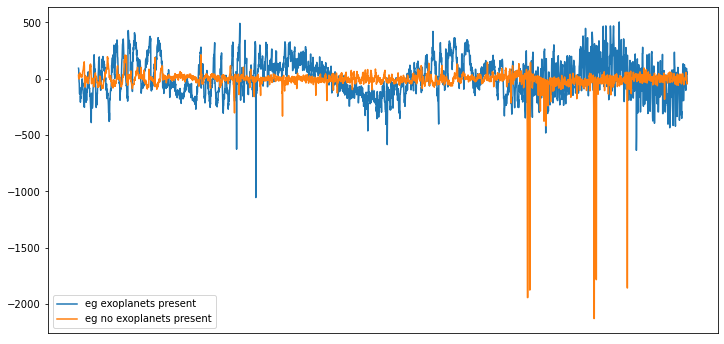

In [32]:
plt.figure(figsize=(12, 6))
ax = plt.gca() #get current axis
ax.axes.xaxis.set_visible(False)
plt.plot(df_train_trans_data[0], label='eg exoplanets present')
plt.plot(df_train_trans_data[100], label='eg no exoplanets present') #has no exoplanet
plt.legend()
plt.show()

- clearly visibile sinusodial wave in case of present exoplanet
- in both cases cleary visible outliers which should be adressed
- flux values have different magnitudes

## Machine Learning Model
### Baseline Models
- First check the difficulty of the problem with a couple of baseline models
    - No further preprocessing or hyperparameter tuning
    - Simple accracy score
- Split train data into train and validation data
    - For hyperparameter tuning I will use cross-validation instead

In [74]:
#Split into train and validate data
X = df_train.iloc[:, 1:].values
y = df_train.iloc[:, :1].values
y = y.reshape(y.shape[0])

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, stratify=y, random_state=1234)

In [91]:
print(f'Samples in trainings data:\t{X_train.shape[0]}')
print(f'Samples in validation data:\t{X_val.shape[0]}')

Samples in trainings data:	4069
Samples in validation data:	1018


In [79]:
#list of baseline models
model_names = ["Logistic_Regression", "Random_Forest", "AdaBoost", "KNN", "Linear_SVC", "Naive_Bayes"]

model_list = [LogisticRegression()
               , RandomForestClassifier()
               , AdaBoostClassifier()
               , KNeighborsClassifier()
               , SVC(kernel="linear")
               , GaussianNB()]

In [89]:
#train and predict on baseline models
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train_scaled = std_scaler.transform(X_train)
X_val_scaled = std_scaler.transform(X_val)
for i, model in enumerate(model_list):
    start = timer()
    model.fit(X_train_scaled, y_train)
    print(f'Model: {model_names[i]}')
    print(f'Trainings  Score:\t{model.score(X_train_scaled, y_train):0.4f}')
    print(f'Validation Score:\t{model.score(X_val_scaled, y_val):0.4f}')
    end = timer()
    print(f'Elapsed Time:\t{end - start:0.2f}s\n')

/home/clemens/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model: Logistic_Regression
Trainings  Score: 0.9934
Validation Score: 0.9892
Elapsed Time: 2.06s

Model: Random_Forest
Trainings  Score: 1.0000
Validation Score: 0.9931
Elapsed Time: 9.11s

Model: AdaBoost
Trainings  Score: 1.0000
Validation Score: 0.9921
Elapsed Time: 75.49s

Model: KNN
Trainings  Score: 0.9926
Validation Score: 0.9931
Elapsed Time: 117.73s

Model: Linear_SVC
Trainings  Score: 0.9941
Validation Score: 0.9862
Elapsed Time: 12.00s

Model: Naive_Bayes
Trainings  Score: 0.0329
Validation Score: 0.0255
Elapsed Time: 0.90s



- All models (except naive bayes) show very good results
- KNN and AdaBoost take to long to train
- Random Forest has highest accuracy while being resonable fast to train
- Next step is to improve perfomance of random forest further by tweaking the hyperparameters and preprocessing